# New York City taxi trip durantion

- [Kaggle](https://www.kaggle.com/c/nyc-taxi-trip-duration)
- Visualization from [maheshdadhich](https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial)

In [41]:
import mlflow
import mlflow.sklearn

import numpy as np
import pandas as pd
import math

from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Read `train.csv`

In [44]:
train_df = pd.read_csv("data/train.csv", sep=",", skipinitialspace=True)

#### Data exploration

In [13]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


#### Trip duration

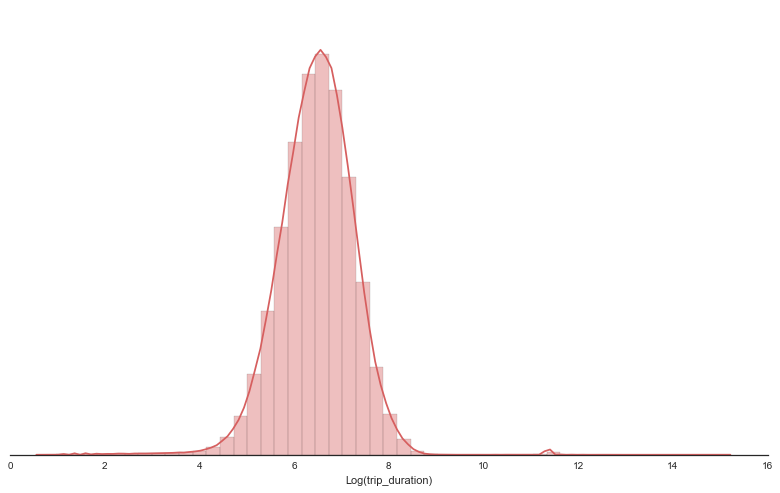

In [15]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)',
             bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

It is clear with the above histogram and kernel density plot that the trip-durations are like Gaussian and few trips have very large duration, like ~350000 seconds which is 100 hours (which is weird, as long as it isn't an intercity taxi ride from NYC to SF or Alaska), while most of the trips are e^4 = 1 minute to e^8 ~ 60 minutes. and probably are taken inside Manhattan or in new york only.
______

#### Heatmap by pickup point

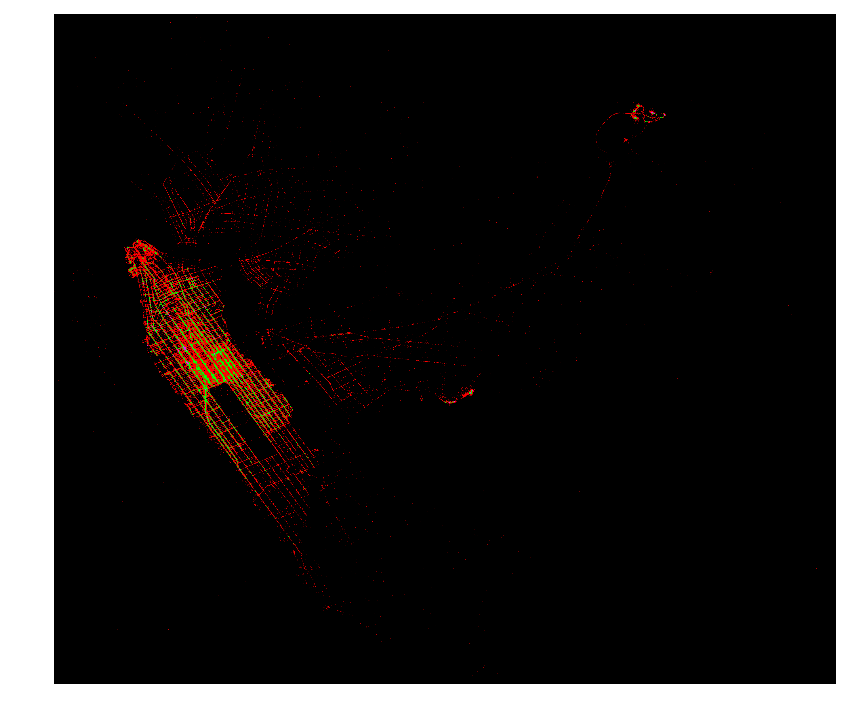

In [37]:
df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
train_data_new = df.copy()

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//50) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 255
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off()

- Red points signifies that 1-10 trips in the given data have that point as pickup point
- Green points signifies that more than 10-50 trips in the given data have that point as pickup point
- Yellow points signifies that more than 50+ trips in the given data have that point as pickup point
___

#### Heatmap by dropoff point

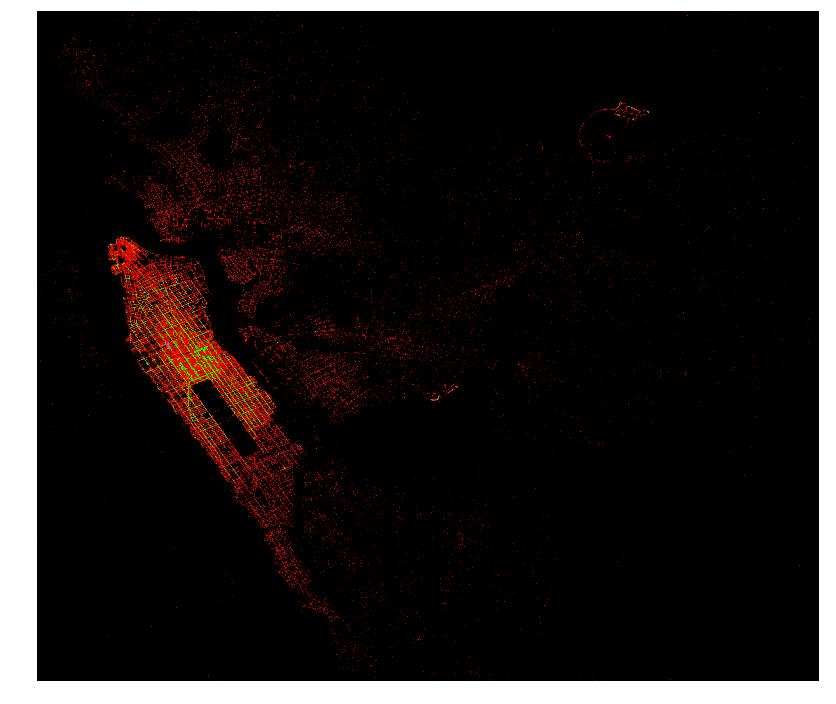

In [18]:
# df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
# df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
# df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
# df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
# train_data_new = df.copy()

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(train_data_new.groupby(['drop_lat_new', 'drop_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['drop_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['drop_lat_new']==i]['drop_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['drop_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//50) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 255
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off()

### Feature engineering

In [3]:
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    """ function was taken from beluga's notebook as this function works on array
    while my function used to work on individual elements and was noticably slow"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [4]:
train_data = train_df.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_month'] = train_data['pickup_datetime'].dt.month
train_data.loc[:, 'hour'] = train_data['pickup_datetime'].dt.hour
train_data.loc[:, 'week_of_year'] = train_data['pickup_datetime'].dt.weekofyear
train_data.loc[:, 'day_of_year'] = train_data['pickup_datetime'].dt.dayofyear
train_data.loc[:, 'day_of_week'] = train_data['pickup_datetime'].dt.dayofweek
train_data.loc[:,'hvsine_pick_drop'] = haversine_(train_data['pickup_latitude'].values,
                                                  train_data['pickup_longitude'].values,
                                                  train_data['dropoff_latitude'].values,
                                                  train_data['dropoff_longitude'].values)
train_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train_data['pickup_latitude'].values,
                                                             train_data['pickup_longitude'].values,
                                                             train_data['dropoff_latitude'].values,
                                                             train_data['dropoff_longitude'].values)
train_data.loc[:,'bearing'] = bearing_array(train_data['pickup_latitude'].values,
                                            train_data['pickup_longitude'].values,
                                            train_data['dropoff_latitude'].values,
                                            train_data['dropoff_longitude'].values)

In [22]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_month,hour,week_of_year,day_of_year,day_of_week,hvsine_pick_drop,manhtn_pick_drop,bearing
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,17,11,74,0,1.498521,1.735433,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,23,164,6,1.805507,2.430506,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,3,19,1,6.385098,8.203575,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,19,14,97,2,1.485498,1.661331,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,13,12,86,5,1.188588,1.199457,179.473585


In [30]:
train_data[["pick_month", "week_of_year", "day_of_year"]].describe()

,pick_month,week_of_year,day_of_year
count,1.458644e+06,1.458644e+06,1.458644e+06
mean,3.516818e+00,1.383993e+01,9.183607e+01
std,1.681038e+00,8.564756e+00,5.156608e+01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.000000e+00,7.000000e+00,4.800000e+01
50%,4.000000e+00,1.300000e+01,9.200000e+01
75%,5.000000e+00,2.000000e+01,1.360000e+02
max,6.000000e+00,5.300000e+01,1.820000e+02


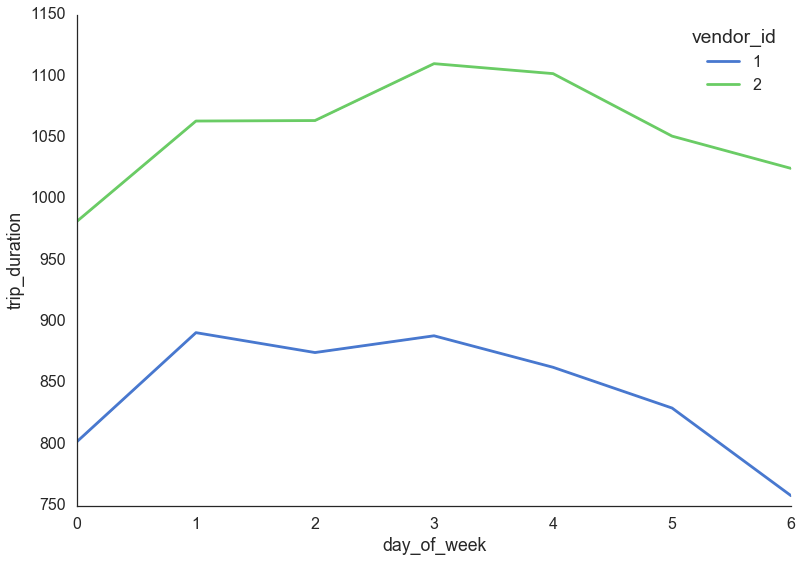

In [23]:
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

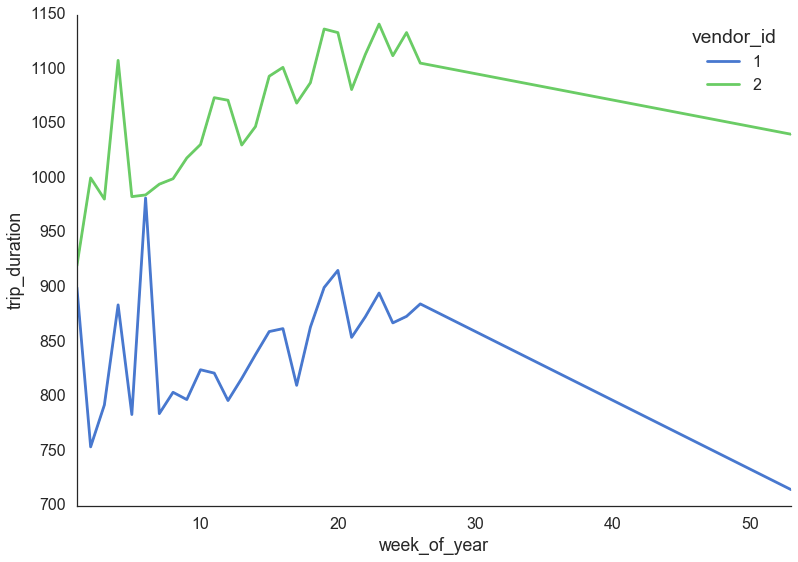

In [25]:
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id','week_of_year'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="week_of_year", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

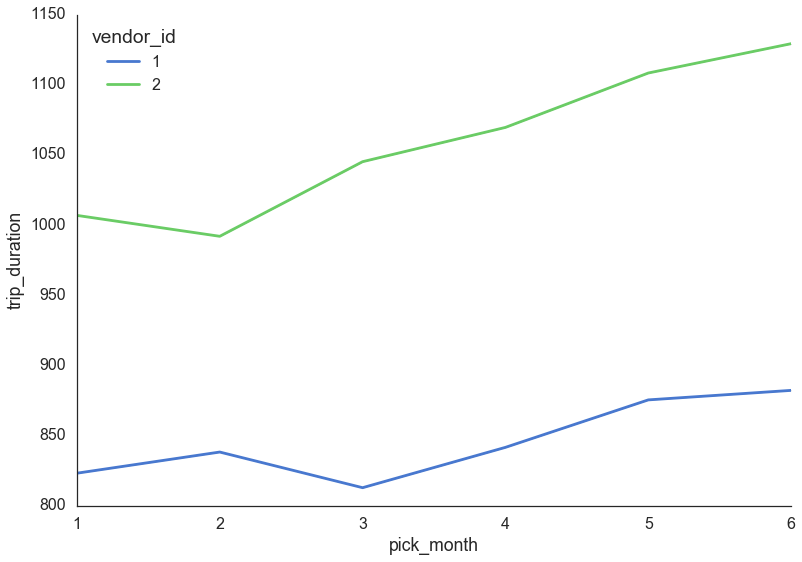

In [26]:
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id','pick_month'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="pick_month", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

It's clear that the vendor 1 is taking more time than vendor 2 on all the days of the week, we can also subset data frame based on the month and that will also give us the same results. The difference between the average time taken by vendor 1 is ~250 seconds more than vendor 2.
___

### Pickup and dropoff clustering

In [5]:
def assign_cluster(df, k):
    """function to assign clusters """
    df_pick = df[['pickup_longitude','pickup_latitude']]
    df_drop = df[['dropoff_longitude','dropoff_latitude']]
    """I am using initialization as from the output of
    k-means from my local machine to save time in this kernel"""
    init = np.array([[ -73.98737616,   40.72981533],
       [-121.93328857,   37.38933945],
       [ -73.78423222,   40.64711269],
       [ -73.9546417 ,   40.77377538],
       [ -66.84140269,   36.64537175],
       [ -73.87040541,   40.77016484],
       [ -73.97316185,   40.75814346],
       [ -73.98861094,   40.7527791 ],
       [ -72.80966949,   51.88108444],
       [ -76.99779701,   38.47370625],
       [ -73.96975298,   40.69089596],
       [ -74.00816622,   40.71414939],
       [ -66.97216034,   44.37194443],
       [ -61.33552933,   37.85105133],
       [ -73.98001393,   40.7783577 ],
       [ -72.00626526,   43.20296402],
       [ -73.07618713,   35.03469086],
       [ -73.95759366,   40.80316361],
       [ -79.20167796,   41.04752096],
       [ -74.00106031,   40.73867723]])
    k_means_pick = KMeans(n_clusters=k, init=init, n_init=1)
    k_means_pick.fit(df_pick)
    clust_pick = k_means_pick.labels_
    df['label_pick'] = clust_pick.tolist()
    df['label_drop'] = k_means_pick.predict(df_drop)
    return df, k_means_pick

In [6]:
train_cl, k_means = assign_cluster(train_data, 20)  # make it 100 when extracting features 
centroid_pickups = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
centroid_dropoff = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])
centroid_pickups['label_pick'] = centroid_pickups.index
centroid_dropoff['label_drop'] = centroid_dropoff.index
#centroid_pickups.head()
train_cl = pd.merge(train_cl, centroid_pickups, how='left', on=['label_pick'])
train_cl = pd.merge(train_cl, centroid_dropoff, how='left', on=['label_drop'])
#train_cl.head()

In [7]:
train_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(train_cl['pickup_latitude'].values,
                                                  train_cl['pickup_longitude'].values,
                                                  train_cl['centroid_pick_lat'].values,
                                                  train_cl['centroid_pick_long'].values)
train_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(train_cl['dropoff_latitude'].values,
                                                  train_cl['dropoff_longitude'].values,
                                                  train_cl['centroid_drop_lat'].values,
                                                  train_cl['centroid_drop_long'].values)
train_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(train_cl['centroid_pick_lat'].values,
                                                    train_cl['centroid_pick_long'].values,
                                                    train_cl['centroid_drop_lat'].values,
                                                    train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(train_cl['pickup_latitude'].values,
                                                             train_cl['pickup_longitude'].values,
                                                             train_cl['centroid_pick_lat'].values, 
                                                             train_cl['centroid_pick_long'].values)
train_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(train_cl['dropoff_latitude'].values,
                                                             train_cl['dropoff_longitude'].values,
                                                             train_cl['centroid_drop_lat'].values, 
                                                             train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(train_cl['centroid_pick_lat'].values,
                                                               train_cl['centroid_pick_long'].values,
                                                               train_cl['centroid_drop_lat'].values,
                                                               train_cl['centroid_drop_long'].values)

train_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(train_cl['pickup_latitude'].values,
                                                      train_cl['pickup_longitude'].values,
                                                      train_cl['centroid_pick_lat'].values, 
                                                      train_cl['centroid_pick_long'].values)
train_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(train_cl['dropoff_latitude'].values,
                                                      train_cl['dropoff_longitude'].values,
                                                      train_cl['centroid_drop_lat'].values, 
                                                      train_cl['centroid_drop_long'].values)
train_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(train_cl['centroid_pick_lat'].values,
                                                        train_cl['centroid_pick_long'].values,
                                                        train_cl['centroid_drop_lat'].values, 
                                                        train_cl['centroid_drop_long'].values)

### Read `test.csv`

In [45]:
test_df = pd.read_csv('data/test.csv', sep=",", skipinitialspace=True)

In [9]:
test_data = test_df.copy()
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data.loc[:, 'pick_month'] = test_data['pickup_datetime'].dt.month
test_data.loc[:, 'hour'] = test_data['pickup_datetime'].dt.hour
test_data.loc[:, 'week_of_year'] = test_data['pickup_datetime'].dt.weekofyear
test_data.loc[:, 'day_of_year'] = test_data['pickup_datetime'].dt.dayofyear
test_data.loc[:, 'day_of_week'] = test_data['pickup_datetime'].dt.dayofweek

test_data.loc[:,'hvsine_pick_drop'] = haversine_(test_data['pickup_latitude'].values,
                                                 test_data['pickup_longitude'].values,
                                                 test_data['dropoff_latitude'].values, 
                                                 test_data['dropoff_longitude'].values)
test_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(test_data['pickup_latitude'].values,
                                                            test_data['pickup_longitude'].values,
                                                            test_data['dropoff_latitude'].values,
                                                            test_data['dropoff_longitude'].values)
test_data.loc[:,'bearing'] = bearing_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values,
                                           test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)

test_data['label_pick'] = k_means.predict(test_data[['pickup_longitude','pickup_latitude']])
test_data['label_drop'] = k_means.predict(test_data[['dropoff_longitude','dropoff_latitude']])
test_cl = pd.merge(test_data, centroid_pickups, how='left', on=['label_pick'])
test_cl = pd.merge(test_cl, centroid_dropoff, how='left', on=['label_drop'])

test_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(test_cl['pickup_latitude'].values,
                                                 test_cl['pickup_longitude'].values,
                                                 test_cl['centroid_pick_lat'].values,
                                                 test_cl['centroid_pick_long'].values)
test_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(test_cl['dropoff_latitude'].values,
                                                 test_cl['dropoff_longitude'].values,
                                                 test_cl['centroid_drop_lat'].values,
                                                 test_cl['centroid_drop_long'].values)
test_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(test_cl['centroid_pick_lat'].values,
                                                   test_cl['centroid_pick_long'].values,
                                                   test_cl['centroid_drop_lat'].values,
                                                   test_cl['centroid_drop_long'].values)
test_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(test_cl['pickup_latitude'].values,
                                                            test_cl['pickup_longitude'].values,
                                                            test_cl['centroid_pick_lat'].values,
                                                            test_cl['centroid_pick_long'].values)
test_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(test_cl['dropoff_latitude'].values,
                                                            test_cl['dropoff_longitude'].values,
                                                            test_cl['centroid_drop_lat'].values,
                                                            test_cl['centroid_drop_long'].values)
test_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(test_cl['centroid_pick_lat'].values,
                                                              test_cl['centroid_pick_long'].values,
                                                              test_cl['centroid_drop_lat'].values,
                                                              test_cl['centroid_drop_long'].values)

test_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(test_cl['pickup_latitude'].values,
                                                     test_cl['pickup_longitude'].values,
                                                     test_cl['centroid_pick_lat'].values,
                                                     test_cl['centroid_pick_long'].values)
test_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(test_cl['dropoff_latitude'].values,
                                                     test_cl['dropoff_longitude'].values, 
                                                     test_cl['centroid_drop_lat'].values, 
                                                     test_cl['centroid_drop_long'].values)
test_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(test_cl['centroid_pick_lat'].values, 
                                                       test_cl['centroid_pick_long'].values, 
                                                       test_cl['centroid_drop_lat'].values, 
                                                       test_cl['centroid_drop_long'].values)

### Model

In [10]:
train = train_cl
test = test_cl

coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)

train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [11]:
train['store_and_fwd_flag_int'] = np.where(train['store_and_fwd_flag']=='N', 0, 1)
test['store_and_fwd_flag_int'] = np.where(test['store_and_fwd_flag']=='N', 0, 1)

In [12]:
y = np.log(train['trip_duration'].values + 1)

In [14]:
feature_names = list(train.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(train.columns, test.columns)))
print("")
do_not_use_for_training = ['pick_date','id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features is {}.".format(len(feature_names)))

Difference of features in train and test are ['dropoff_datetime' 'trip_duration']

We will be using following features for training ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pick_month', 'hour', 'week_of_year', 'day_of_year', 'day_of_week', 'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing', 'label_pick', 'label_drop', 'centroid_pick_long', 'centroid_pick_lat', 'centroid_drop_long', 'centroid_drop_lat', 'hvsine_pick_cent_p', 'hvsine_drop_cent_d', 'hvsine_cent_p_cent_d', 'manhtn_pick_cent_p', 'manhtn_drop_cent_d', 'manhtn_cent_p_cent_d', 'bearing_pick_cent_p', 'bearing_drop_cent_p', 'bearing_cent_p_cent_d', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'store_and_fwd_flag_int'].

Total number of features is 34.


In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [16]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 15, watchlist, early_stopping_rounds=2,
                  maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.22802	valid-rmse:4.22911
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.9821	valid-rmse:2.9834
[2]	train-rmse:2.11766	valid-rmse:2.11927
[3]	train-rmse:1.51915	valid-rmse:1.52153
[4]	train-rmse:1.11706	valid-rmse:1.12029
[5]	train-rmse:0.852422	valid-rmse:0.856661
[6]	train-rmse:0.679245	valid-rmse:0.684948
[7]	train-rmse:0.574056	valid-rmse:0.581319
[8]	train-rmse:0.514582	valid-rmse:0.523381
[9]	train-rmse:0.4656	valid-rmse:0.475827
[10]	train-rmse:0.447917	valid-rmse:0.458851
[11]	train-rmse:0.432664	valid-rmse:0.444347
[12]	train-rmse:0.417668	valid-rmse:0.430095
[13]	train-rmse:0.414139	valid-rmse:0.427026
[14]	train-rmse:0.407281	valid-rmse:0.42092
Modeling RMSLE 0.42092


In [17]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 5,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 15, watchlist, early_stopping_rounds=2,
                  maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.22878	valid-rmse:4.2298
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.98722	valid-rmse:2.98827
[2]	train-rmse:2.12568	valid-rmse:2.12701
[3]	train-rmse:1.52892	valid-rmse:1.53075
[4]	train-rmse:1.13094	valid-rmse:1.13309
[5]	train-rmse:0.871467	valid-rmse:0.874043
[6]	train-rmse:0.700021	valid-rmse:0.703162
[7]	train-rmse:0.597329	valid-rmse:0.600999
[8]	train-rmse:0.540258	valid-rmse:0.544267
[9]	train-rmse:0.497016	valid-rmse:0.501394
[10]	train-rmse:0.480656	valid-rmse:0.485151
[11]	train-rmse:0.466196	valid-rmse:0.470726
[12]	train-rmse:0.454213	valid-rmse:0.458914
[13]	train-rmse:0.450928	valid-rmse:0.455664
[14]	train-rmse:0.444879	valid-rmse:0.449784
Modeling RMSLE 0.44978


In [18]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 15,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 15, watchlist, early_stopping_rounds=2,
                  maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.22801	valid-rmse:4.22912
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.98066	valid-rmse:2.98204
[2]	train-rmse:2.11449	valid-rmse:2.11649
[3]	train-rmse:1.51522	valid-rmse:1.51837
[4]	train-rmse:1.11004	valid-rmse:1.11449
[5]	train-rmse:0.84184	valid-rmse:0.84862
[6]	train-rmse:0.666676	valid-rmse:0.67688
[7]	train-rmse:0.558444	valid-rmse:0.5726
[8]	train-rmse:0.495242	valid-rmse:0.513451
[9]	train-rmse:0.441687	valid-rmse:0.463918
[10]	train-rmse:0.422128	valid-rmse:0.446515
[11]	train-rmse:0.406553	valid-rmse:0.433626
[12]	train-rmse:0.388877	valid-rmse:0.418573
[13]	train-rmse:0.385241	valid-rmse:0.416021
[14]	train-rmse:0.377372	valid-rmse:0.410052
Modeling RMSLE 0.41005


### With MLFLOW 

In [21]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [39]:
def my_training_function(xgb_pars):
    
    # Useful for multiple runs (only doing one run in this sample notebook)    
    with mlflow.start_run():
        
        # Train model, watch on dval
        model = xgb.train(xgb_pars, dtrain, 15, watchlist, early_stopping_rounds=2, maximize=False, verbose_eval=1)
        
        print('Modeling RMSLE %.5f' % model.best_score)
        
        # Evaluate metrics
        val_pred = model.predict(dvalid)
                
        (rmse, mae, r2) = eval_metrics(val_pred, dvalid.get_label())
        
        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("max_depth", xgb_pars["max_depth"])
        mlflow.log_param("lambda", xgb_pars["lambda"])
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(model, "model")

In [42]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.4, 'colsample_bytree': 0.3, 'max_depth': 15,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

my_training_function(xgb_pars)

[0]	train-rmse:3.63258	valid-rmse:3.63382
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.21332	valid-rmse:2.21523
[2]	train-rmse:1.37965	valid-rmse:1.38302
[3]	train-rmse:0.900623	valid-rmse:0.906956
[4]	train-rmse:0.645928	valid-rmse:0.65616
[5]	train-rmse:0.522746	valid-rmse:0.537008
[6]	train-rmse:0.463778	valid-rmse:0.482674
[7]	train-rmse:0.436898	valid-rmse:0.459889
[8]	train-rmse:0.42453	valid-rmse:0.451338
[9]	train-rmse:0.39466	valid-rmse:0.425487
[10]	train-rmse:0.391677	valid-rmse:0.423714
[11]	train-rmse:0.384419	valid-rmse:0.419534
[12]	train-rmse:0.370932	valid-rmse:0.409131
[13]	train-rmse:0.369246	valid-rmse:0.408418
[14]	train-rmse:0.363598	valid-rmse:0.405046
Modeling RMSLE 0.40505


In [43]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.4, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 0.1, 'nthread': -1, 'booster' : 'gbtree', 'silent': 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

my_training_function(xgb_pars)

[0]	train-rmse:3.63183	valid-rmse:3.63309
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.21429	valid-rmse:2.21612
[2]	train-rmse:1.38393	valid-rmse:1.38664
[3]	train-rmse:0.907025	valid-rmse:0.911725
[4]	train-rmse:0.657891	valid-rmse:0.664369
[5]	train-rmse:0.539794	valid-rmse:0.548023
[6]	train-rmse:0.482757	valid-rmse:0.492676
[7]	train-rmse:0.458201	valid-rmse:0.469448
[8]	train-rmse:0.448122	valid-rmse:0.46025
[9]	train-rmse:0.421473	valid-rmse:0.434901
[10]	train-rmse:0.418875	valid-rmse:0.432844
[11]	train-rmse:0.411703	valid-rmse:0.426402
[12]	train-rmse:0.400429	valid-rmse:0.415934
[13]	train-rmse:0.399451	valid-rmse:0.415214
[14]	train-rmse:0.394912	valid-rmse:0.411562
Modeling RMSLE 0.41156
